**Сравнение различных конфигураци модели YOLO 11 в задаче детекции людей**

Посколько теперь у нас есть собственный датасет на 5000 фотографий, который по создали путем аугментации данных и предварительно уже разделили их по папкам на train, val и test - нам остается только провести обучение и сравнение метрик на разных версиях модели. Сравнивать будем от nano до extra-large версии (если позволят ресурсы).

**Метрики сравнения:**
- mAP 0.5 (средняя точность при IoU=0.5)
- mAP 0.5:0.95 (средняя точность при разных IoU от 0.5 до 0.95)
- Detection Speed (время инференса)
- Precision
- Recall
- F1-Score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics opencv-python tqdm

In [7]:
import os
import cv2
from tqdm import tqdm
from ultralytics import YOLO
import shutil
import yaml
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pathlib import Path

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
Tesla T4


**Начнем наши эксперименты с самой маленькой модели - YOLO 11 nano**

In [ ]:
# Загружаем предобученную модель
model = YOLO('yolo11n.pt')

100%|██████████| 5.35M/5.35M [00:00<00:00, 141MB/s]


In [ ]:
# Запускаем обучение
model.train(
    data='/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/final_dataset/data.yaml',
    epochs=50,                           # Количество эпох
    imgsz=640,                           # Размер картинок
    batch=8,                             # Размер батча
    device=0,                            # GPU device
    workers=2,                           # Количество воркеров для загрузки данных
    save=True,                           # Сохранять чекпоинты
    save_period=10,                      # Сохранять модель каждые 10 эпох
    verbose=True                         # Показывать лог обучения
)

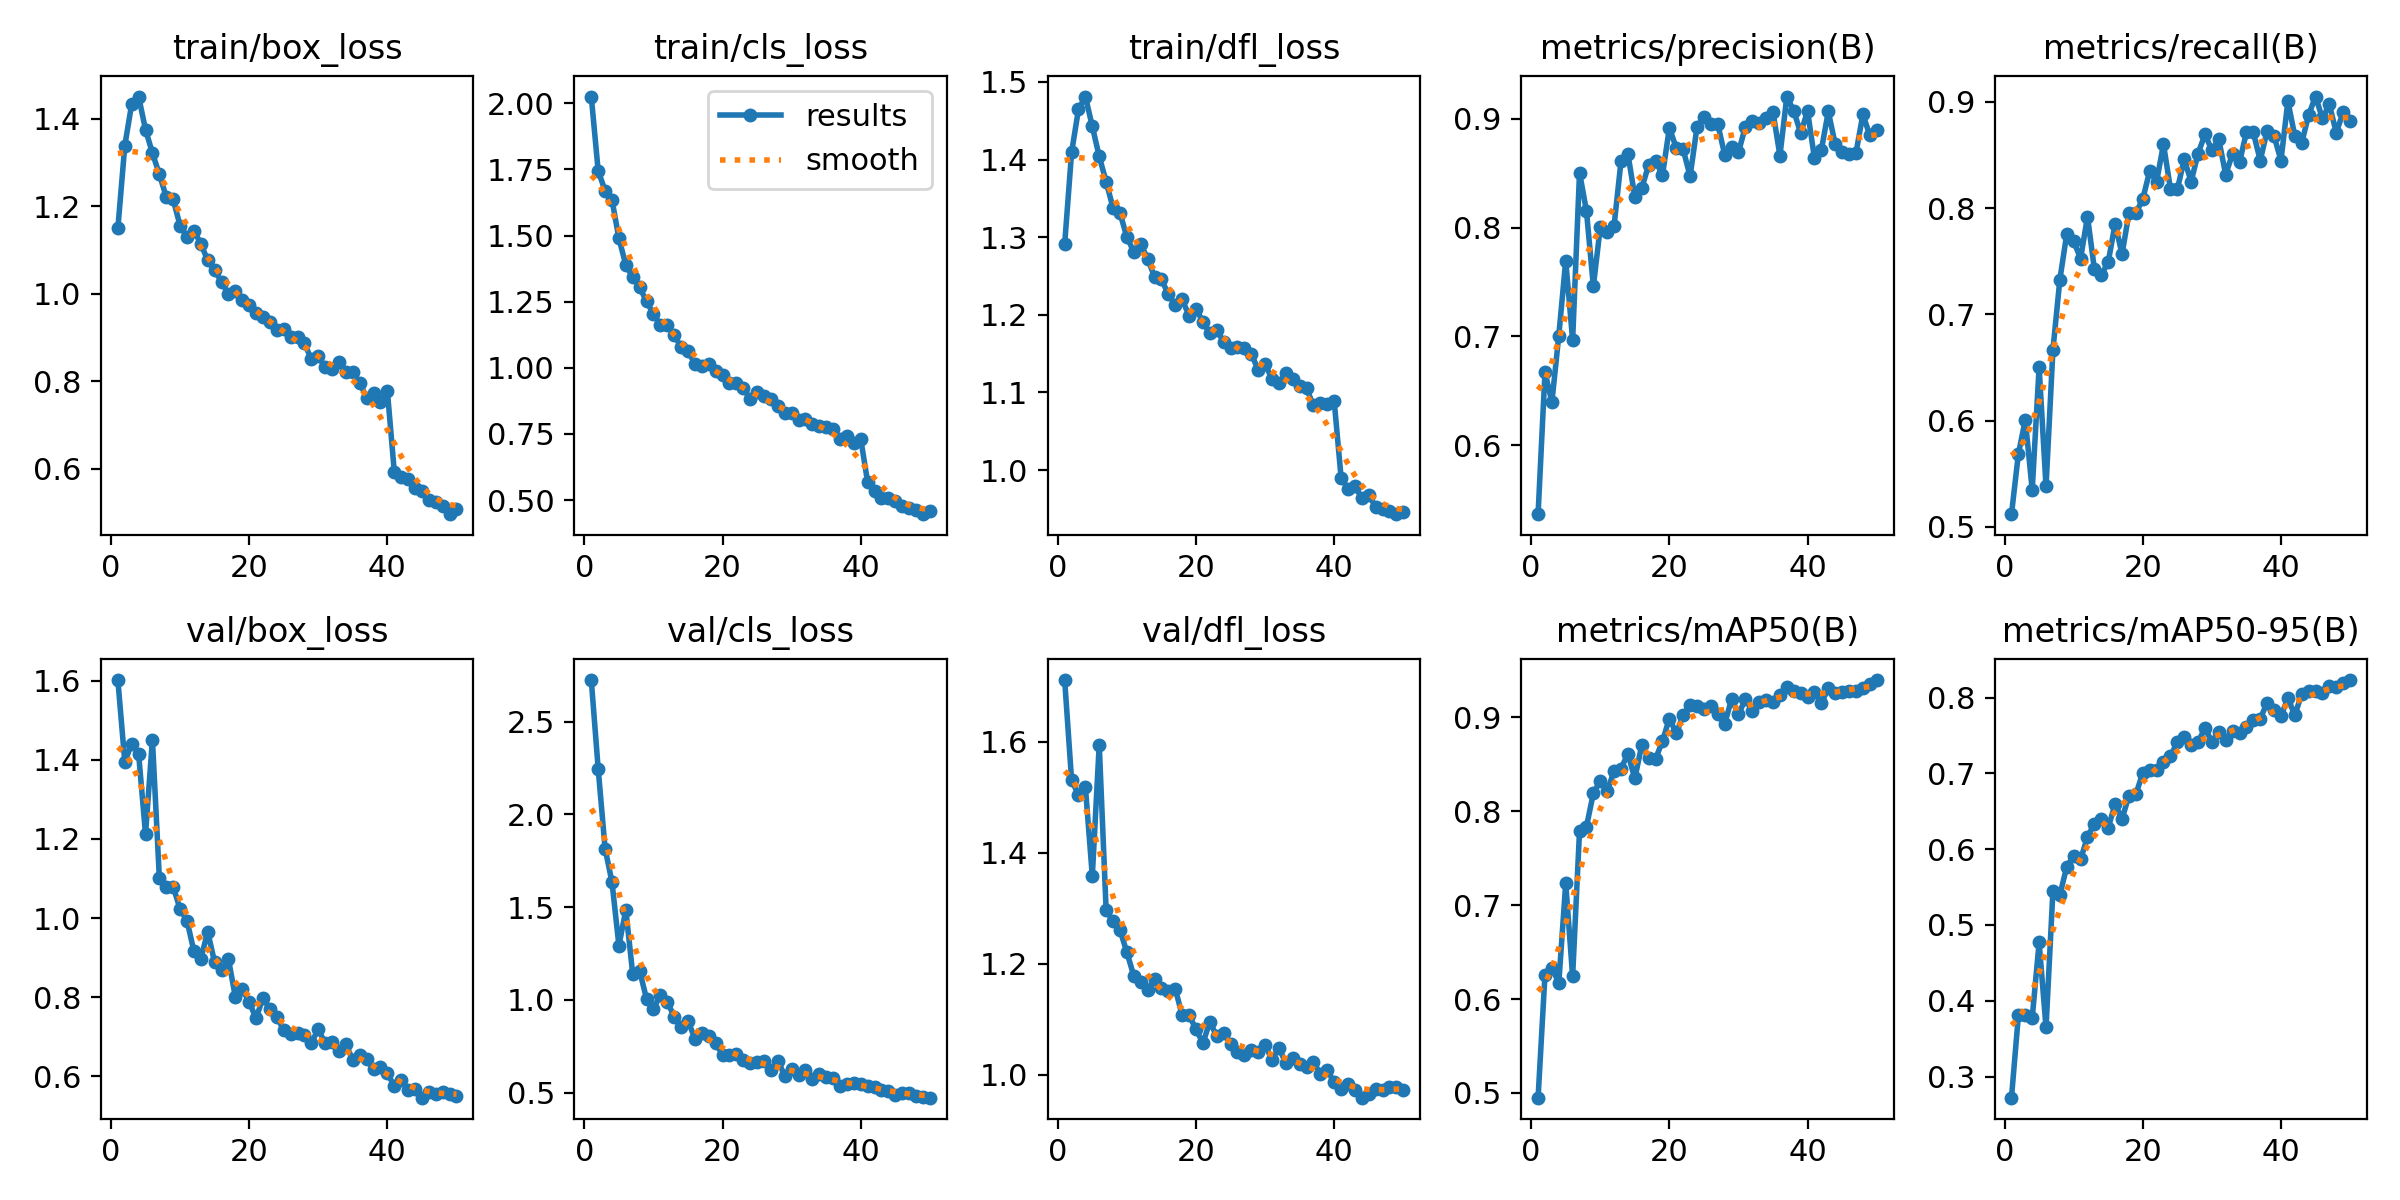

In [ ]:
# Путь до папки, куда Ultralytics сохранил графики
training_run_dir = '/content/runs/detect/train'

# Посмотрим графики
display(Image(filename=os.path.join(training_run_dir, 'results.png')))

**Что хорошо:**
- Loss'ы (box_loss, cls_loss, dfl_loss) уверенно и стабильно падают

- mAP 0.5 и mAP 0.5:0.95 растут до очень приличных значений

- Precision и Recall также увеличиваются

**Что может быть проблемой:**
- Процесс длился 2 часа на YOLO11n (а это самая лёгкая модель, но возможно это из-за кэширования датасета)

Значит YOLO11s будет тренироваться ещё дольше, особенно если всё оставить как есть



In [ ]:
# Загружаем лучшую модель
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Валидируем модель
metrics = model.val(
    data='/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/final_dataset/data.yaml',
    imgsz=640,
    batch=8,
    split='test',
    device='auto'
)

In [15]:
def print_metrics(metrics):
    print(f"mAP 0.5:   {metrics.box.map50:.4f} (средняя точность при IoU=0.5)")
    print(f"mAP 0.5:0.95: {metrics.box.map:.4f} (средняя точность при разных IoU от 0.5 до 0.95)")
    print(f"Detection Speed: {metrics.speed['inference']:.2f} ms per image (время инференса)")

In [ ]:
# Параметры
conf_threshold = 0.25
iou_threshold = 0.5     # стандартный порог IoU для зачета попадания
image_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/final_dataset/images/test'
label_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/final_dataset/labels/test'
model_path = '/content/runs/detect/train/weights/best.pt'

# Загружаем модель
model = YOLO(model_path)

# Функция для расчёта IoU
def calculate_iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

# Счетчики
total_tp = 0
total_fp = 0
total_fn = 0

# Проходим по всем тестовым изображениям
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

for img_name in tqdm(image_files, desc="Evaluating"):
    img_path = os.path.join(image_dir, img_name)
    label_path_file = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')

    # Загружаем изображение
    img = cv2.imread(img_path)
    height, width = img.shape[:2]

    # Загружаем реальную разметку
    gt_boxes = []
    if os.path.exists(label_path_file):
        with open(label_path_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, bbox_width, bbox_height = map(float, parts)
                    # Преобразуем в формат (x1, y1, x2, y2)
                    x_center *= width
                    y_center *= height
                    bbox_width *= width
                    bbox_height *= height
                    x1 = x_center - bbox_width/2
                    y1 = y_center - bbox_height/2
                    x2 = x_center + bbox_width/2
                    y2 = y_center + bbox_height/2
                    gt_boxes.append([x1, y1, x2, y2])

    # Прогоняем инференс модели
    results = model.predict(source=img_path, imgsz=640, conf=conf_threshold, device='auto', verbose=False)
    preds = results[0].boxes

    # Получаем предсказанные боксы
    pred_boxes = []
    if preds is not None and preds.xyxy is not None:
        for box, conf, cls in zip(preds.xyxy, preds.conf, preds.cls):
            if conf > conf_threshold:
                pred_boxes.append(box.cpu().numpy())

    # Сопоставление предсказаний и реальных боксов
    matched_gt = set()
    matched_pred = set()

    for i, pred in enumerate(pred_boxes):
        for j, gt in enumerate(gt_boxes):
            iou = calculate_iou(pred, gt)
            if iou >= iou_threshold and j not in matched_gt:
                matched_pred.add(i)
                matched_gt.add(j)
                break

    tp = len(matched_pred)
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    total_tp += tp
    total_fp += fp
    total_fn += fn

# Рассчитываем финальные метрики
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

Evaluating: 100%|██████████| 504/504 [00:46<00:00, 10.94it/s]


In [ ]:
# Вывод результатов
print("\nФинальные метрики на тестовом наборе:")
print(f"True Positives (TP): {total_tp}")
print(f"False Positives (FP): {total_fp}")
print(f"False Negatives (FN): {total_fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print_metrics(metrics)


Финальные метрики на тестовом наборе:
True Positives (TP): 697
False Positives (FP): 126
False Negatives (FN): 998
Precision: 0.8469
Recall:    0.4112
F1-Score:  0.5536
mAP 0.5:   0.9515 (средняя точность при IoU=0.5)
mAP 0.5:0.95: 0.8345 (средняя точность при разных IoU от 0.5 до 0.95)

Detection Speed: 12.73 ms per image (время инференса)



**На модели YOLO11n у нас получились довольно неплохие метрики, правда местами хуже, чем до аугментации. Возможно модель просто не справляется с масштабом и разнообразием данных, поэтому мы сохраним эти результаты и попробуем обучить модельку побольше. Посмотрим как изменятся метрики.**

In [ ]:
# Архивируем результаты обучения YOLO11n
shutil.make_archive(
    '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/yolo11n_results',
    'zip',
    '/content/runs/detect/train'
)

print("✅ Результаты YOLO11n сохранены в Google Drive.")

✅ Результаты YOLO11n сохранены в Google Drive.


In [6]:
# Загружаем модель побольше
model = YOLO('yolo11s.pt')

100%|██████████| 18.4M/18.4M [00:00<00:00, 151MB/s]


In [ ]:
# Обучаем
model.train(
    data='/content/final_dataset/data.yaml',
    epochs=40,              # попробуем поменьше эпох
    imgsz=512,              # поменьше картинку поставим - быстрее, без большого ущерба
    batch=64,               # увеличим размер батча - быстрее, надеюсь GPU справится
    name='yolo11s',
    save_period=10,
    workers=2,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=True,
    augment=False           # отключаем runtime-аугментации
)

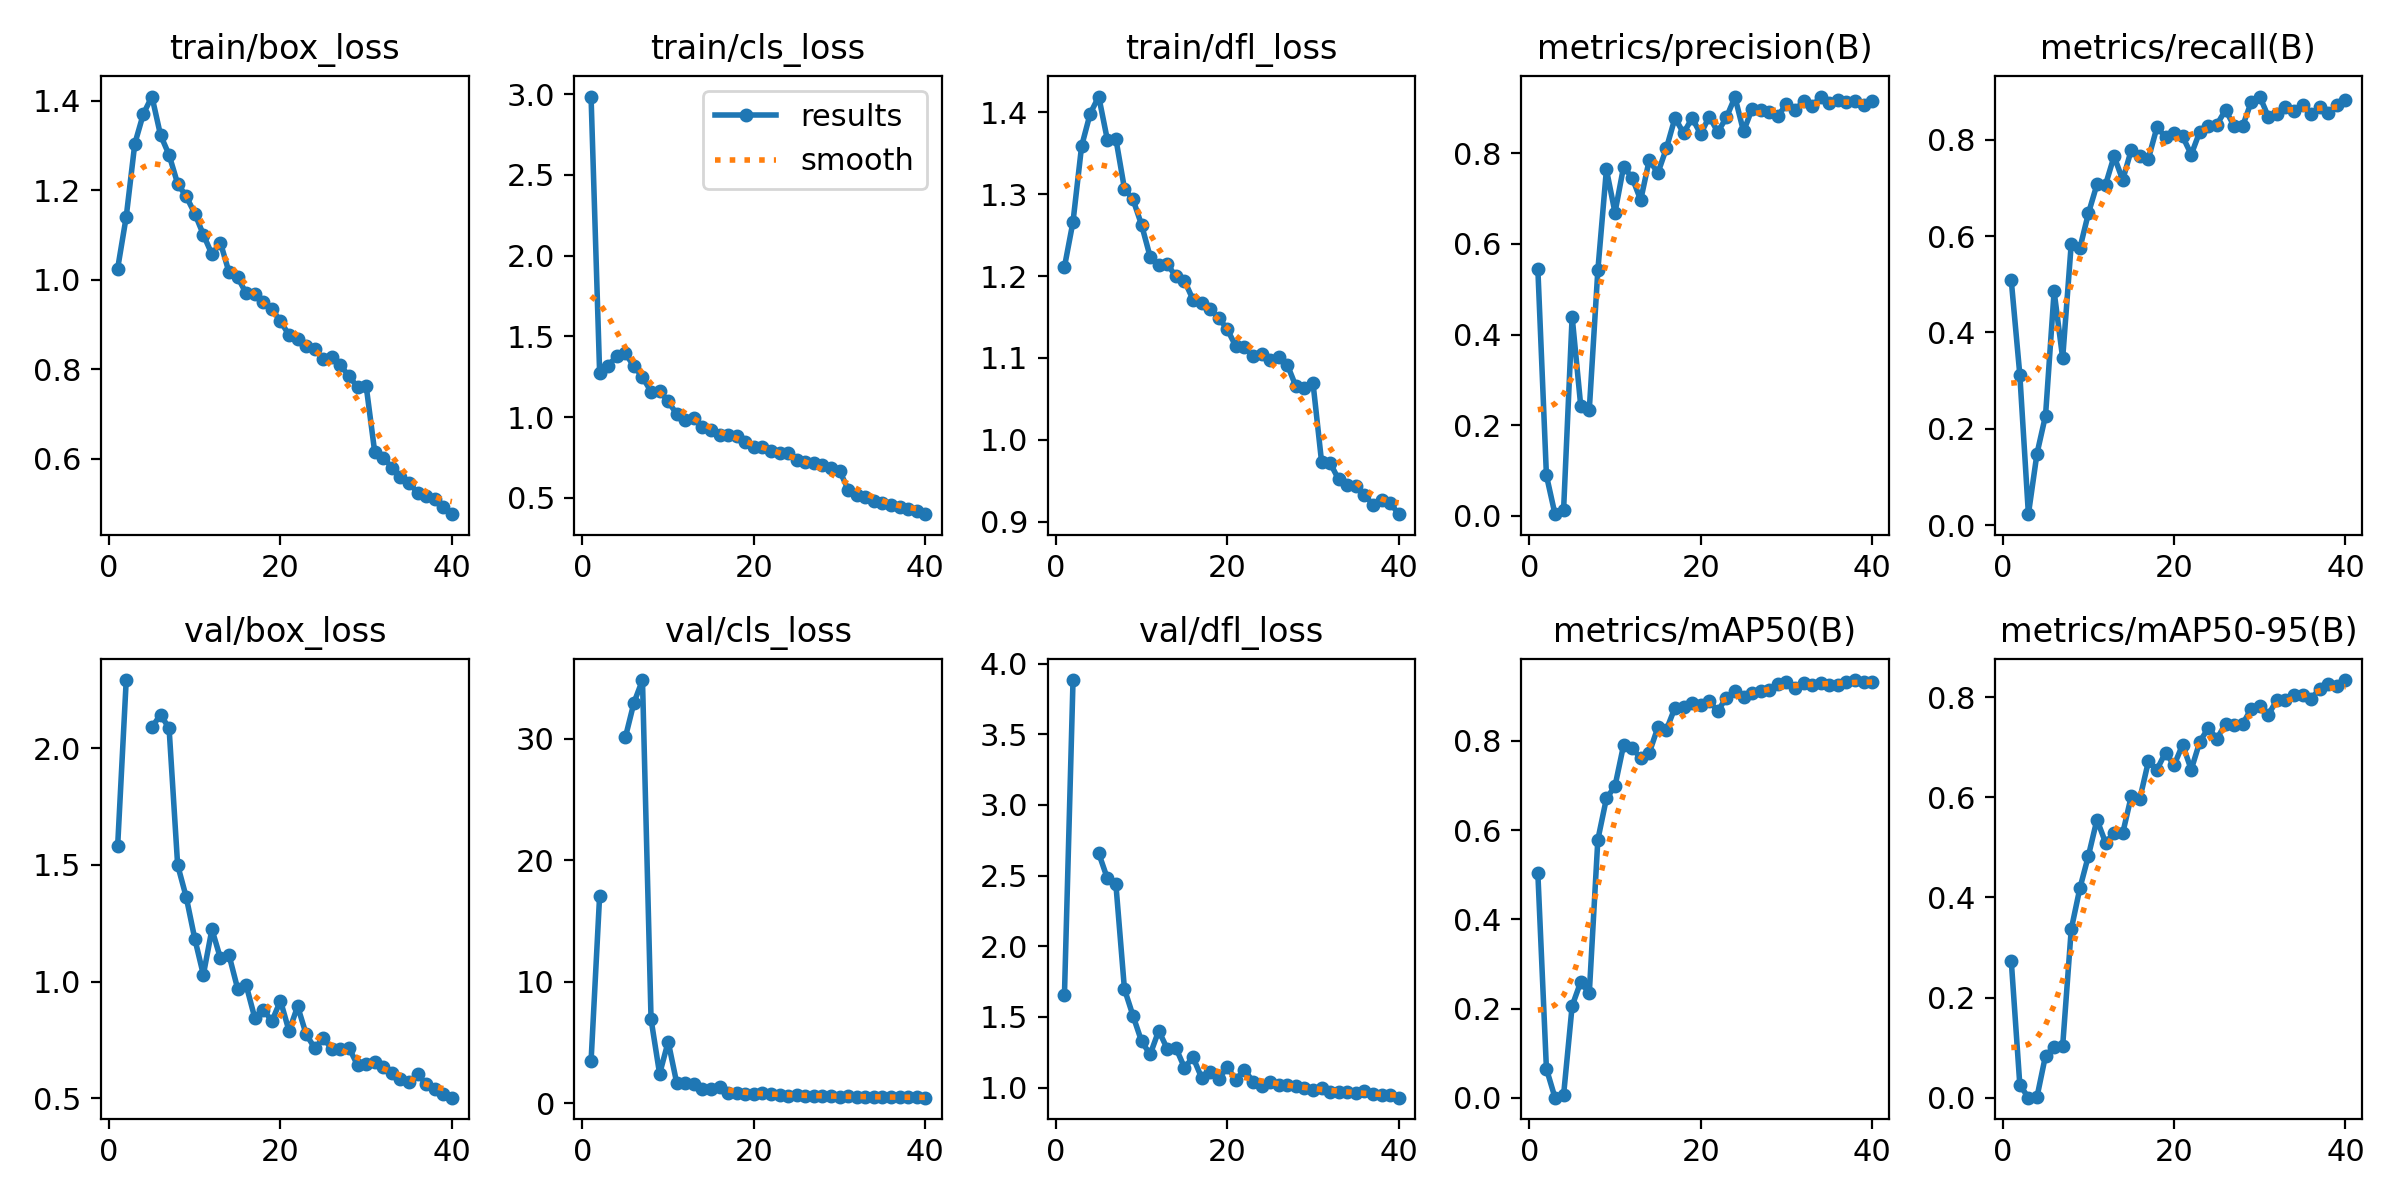

In [17]:
# Путь до папки, куда Ultralytics сохранил графики
training_run_dir = '/content/runs/detect/yolo11s'

# Посмотрим графики
display(Image(filename=os.path.join(training_run_dir, 'results.png')))

**С подгрузкой кэша обучение действительно протекает быстрее  (47 минут) + я немного изменил параметры обучения, чтобы максимально ускорить процесс. Однако 40 эпох это тоже довольно многовато. Для модели medium поставим 30**

In [ ]:
# Загружаем лучшую модель
model = YOLO('/content/runs/detect/yolo11s/weights/best.pt')

# Валидируем модель
metrics = model.val(
    data='/content/final_dataset/data.yaml',
    imgsz=512,
    batch=64,
    split='test',
    device='auto'
)

In [13]:
# Параметры
conf_threshold = 0.25
iou_threshold = 0.5     # стандартный порог IoU для зачета попадания
image_dir = '/content/final_dataset/images/test'
label_dir = '/content/final_dataset/labels/test'

# Функция для расчёта IoU
def calculate_iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

# Счетчики
total_tp = 0
total_fp = 0
total_fn = 0

# Проходим по всем тестовым изображениям
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

for img_name in tqdm(image_files, desc="Evaluating"):
    img_path = os.path.join(image_dir, img_name)
    label_path_file = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')

    # Загружаем изображение
    img = cv2.imread(img_path)
    height, width = img.shape[:2]

    # Загружаем реальную разметку
    gt_boxes = []
    if os.path.exists(label_path_file):
        with open(label_path_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, bbox_width, bbox_height = map(float, parts)
                    # Преобразуем в формат (x1, y1, x2, y2)
                    x_center *= width
                    y_center *= height
                    bbox_width *= width
                    bbox_height *= height
                    x1 = x_center - bbox_width/2
                    y1 = y_center - bbox_height/2
                    x2 = x_center + bbox_width/2
                    y2 = y_center + bbox_height/2
                    gt_boxes.append([x1, y1, x2, y2])

    # Прогоняем инференс модели
    results = model.predict(source=img_path, imgsz=640, conf=conf_threshold, device='auto', verbose=False)
    preds = results[0].boxes

    # Получаем предсказанные боксы
    pred_boxes = []
    if preds is not None and preds.xyxy is not None:
        for box, conf, cls in zip(preds.xyxy, preds.conf, preds.cls):
            if conf > conf_threshold:
                pred_boxes.append(box.cpu().numpy())

    # Сопоставление предсказаний и реальных боксов
    matched_gt = set()
    matched_pred = set()

    for i, pred in enumerate(pred_boxes):
        for j, gt in enumerate(gt_boxes):
            iou = calculate_iou(pred, gt)
            if iou >= iou_threshold and j not in matched_gt:
                matched_pred.add(i)
                matched_gt.add(j)
                break

    tp = len(matched_pred)
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    total_tp += tp
    total_fp += fp
    total_fn += fn

# Рассчитываем финальные метрики
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

Evaluating: 100%|██████████| 504/504 [01:11<00:00,  7.03it/s]


In [16]:
# Вывод результатов
print("\nФинальные метрики на тестовом наборе:")
print(f"True Positives (TP): {total_tp}")
print(f"False Positives (FP): {total_fp}")
print(f"False Negatives (FN): {total_fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print_metrics(metrics)


Финальные метрики на тестовом наборе:
True Positives (TP): 697
False Positives (FP): 113
False Negatives (FN): 998
Precision: 0.8605
Recall:    0.4112
F1-Score:  0.5565
mAP 0.5:   0.9486 (средняя точность при IoU=0.5)
mAP 0.5:0.95: 0.8400 (средняя точность при разных IoU от 0.5 до 0.95)
Detection Speed: 8.11 ms per image (время инференса)


In [22]:
# Архивируем результаты обучения YOLO11s
shutil.make_archive(
    '/content/drive/MyDrive/DL Practice (AITH, spring 2025)/yolo11s_results',
    'zip',
    '/content/runs/detect/yolo11s'
)

print("✅ Результаты YOLO11s сохранены в Google Drive.")

✅ Результаты YOLO11s сохранены в Google Drive.


In [18]:
# Загружаем модель побольше
model = YOLO('yolo11m.pt')

100%|██████████| 38.8M/38.8M [00:00<00:00, 183MB/s]


In [ ]:
# Обучаем
model.train(
    data='/content/final_dataset/data.yaml',
    epochs=30,              # попробуем поменьше эпох
    imgsz=512,
    batch=32,               # батчсайз 32, тк 64 по памяти влез
    name='yolo11m',
    save_period=10,
    workers=2,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=True,
    augment=False           # отключаем runtime-аугментации
)

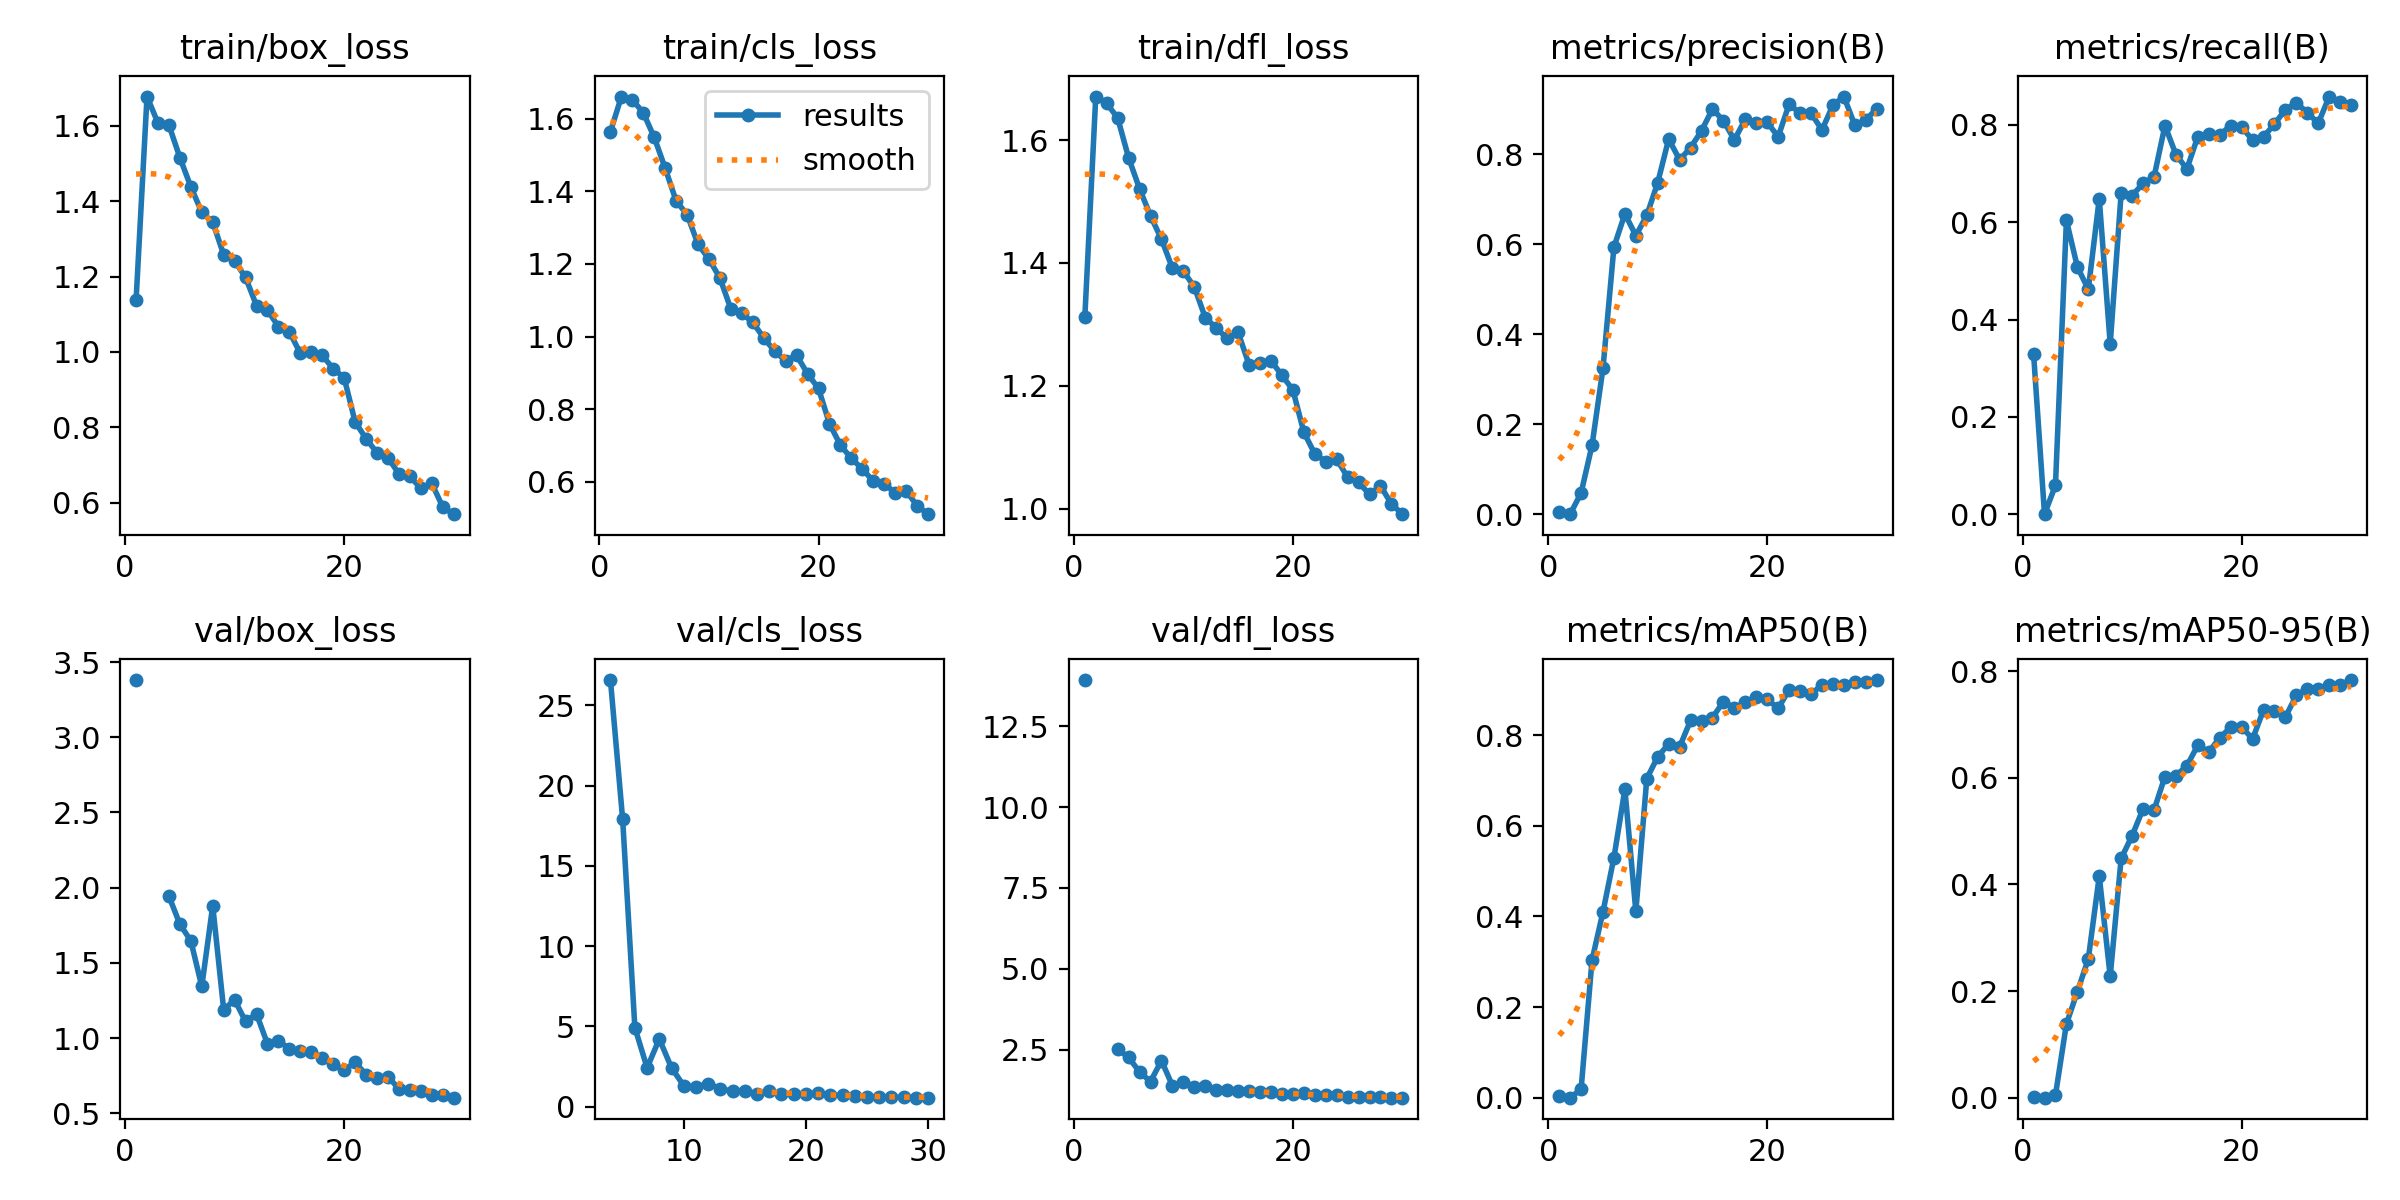

In [23]:
# Путь до папки, куда Ultralytics сохранил графики
training_run_dir = '/content/runs/detect/yolo11m'

# Посмотрим графики
display(Image(filename=os.path.join(training_run_dir, 'results.png')))

In [ ]:
# Загружаем лучшую модель
model = YOLO('/content/runs/detect/yolo11m/weights/best.pt')

# Валидируем модель
metrics = model.val(
    data='/content/final_dataset/data.yaml',
    imgsz=512,
    batch=32,
    split='test',
    device='auto'
)

In [25]:
# Параметры
conf_threshold = 0.25
iou_threshold = 0.5     # стандартный порог IoU для зачета попадания
image_dir = '/content/final_dataset/images/test'
label_dir = '/content/final_dataset/labels/test'

# Функция для расчёта IoU
def calculate_iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

# Счетчики
total_tp = 0
total_fp = 0
total_fn = 0

# Проходим по всем тестовым изображениям
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

for img_name in tqdm(image_files, desc="Evaluating"):
    img_path = os.path.join(image_dir, img_name)
    label_path_file = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')

    # Загружаем изображение
    img = cv2.imread(img_path)
    height, width = img.shape[:2]

    # Загружаем реальную разметку
    gt_boxes = []
    if os.path.exists(label_path_file):
        with open(label_path_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, bbox_width, bbox_height = map(float, parts)
                    # Преобразуем в формат (x1, y1, x2, y2)
                    x_center *= width
                    y_center *= height
                    bbox_width *= width
                    bbox_height *= height
                    x1 = x_center - bbox_width/2
                    y1 = y_center - bbox_height/2
                    x2 = x_center + bbox_width/2
                    y2 = y_center + bbox_height/2
                    gt_boxes.append([x1, y1, x2, y2])

    # Прогоняем инференс модели
    results = model.predict(source=img_path, imgsz=640, conf=conf_threshold, device='auto', verbose=False)
    preds = results[0].boxes

    # Получаем предсказанные боксы
    pred_boxes = []
    if preds is not None and preds.xyxy is not None:
        for box, conf, cls in zip(preds.xyxy, preds.conf, preds.cls):
            if conf > conf_threshold:
                pred_boxes.append(box.cpu().numpy())

    # Сопоставление предсказаний и реальных боксов
    matched_gt = set()
    matched_pred = set()

    for i, pred in enumerate(pred_boxes):
        for j, gt in enumerate(gt_boxes):
            iou = calculate_iou(pred, gt)
            if iou >= iou_threshold and j not in matched_gt:
                matched_pred.add(i)
                matched_gt.add(j)
                break

    tp = len(matched_pred)
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    total_tp += tp
    total_fp += fp
    total_fn += fn

# Рассчитываем финальные метрики
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

Evaluating: 100%|██████████| 504/504 [00:40<00:00, 12.30it/s]


In [26]:
# Вывод результатов
print("\nФинальные метрики на тестовом наборе:")
print(f"True Positives (TP): {total_tp}")
print(f"False Positives (FP): {total_fp}")
print(f"False Negatives (FN): {total_fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print_metrics(metrics)


Финальные метрики на тестовом наборе:
True Positives (TP): 710
False Positives (FP): 182
False Negatives (FN): 985
Precision: 0.7960
Recall:    0.4189
F1-Score:  0.5489
mAP 0.5:   0.9369 (средняя точность при IoU=0.5)
mAP 0.5:0.95: 0.7998 (средняя точность при разных IoU от 0.5 до 0.95)
Detection Speed: 16.95 ms per image (время инференса)


In [27]:
# Архивируем результаты обучения YOLO11s
shutil.make_archive(
    '/content/drive/MyDrive/DL Practice (AITH, spring 2025)/yolo11m_results',
    'zip',
    '/content/runs/detect/yolo11m'
)

print("✅ Результаты YOLO11s сохранены в Google Drive.")

✅ Результаты YOLO11s сохранены в Google Drive.
